# OBJECTIF

L'objectif de ce notebook est d'explorer les données et d'effectuer les premiers test de classification par Deep Learning du set de **test**

In [1]:
# Python libraries:
# to handle datasets
import numpy as np # linear algebra
import random
import time

# Initialization:
np.random.seed(1001)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure
import time


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split

# for sound analysis
import librosa
import librosa.display
import IPython.display as ipd
from scipy import fftpack
from scipy import signal

from tqdm import tqdm_notebook #tqdm

# manage file storage
import feather

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

Using TensorFlow backend.


'1.3.4'

# CREATION DU FICHIER CSV

In [2]:
# Paths definition:
ROOT_AUDIO     = 'DCASE_DATASET' #Directory name where are all wave files
DEV_DATA_PATH       = os.path.join(ROOT_AUDIO, 'dev_data')
EVAL_DATA_PATH      = os.path.join(ROOT_AUDIO, 'eval_data')

def load_sound_file(audio_path, duration=None):
    """
    Loads a sound file
    
    PARAMS
    ======
        audio_path (string) - location to the WAV file to open
    
    RETURNS
    =======
        signal (numpy array) - sound signal
        sampling_rate (float) - sampling rate detected in the file
    """
    multi_channel_data, sampling_rate = librosa.load(audio_path, sr=None, duration=duration)
    signal = np.array(multi_channel_data)
    
    return signal, sampling_rate

def generate_dataset(data_dir):
    """
    Takes a list for WAV files as an input and generate a numpy array with
    the extracted features.
    
    PARAMS
    ======
        data_dir (string) - Root directory to audio files
        
    RETURNS
    =======
        dataset (dataframe) - dataset
    """

    dataset = []
    filepath = []
    
    #create header variable
    header = 'pathname filename machine_id sample_id audio_format machine_type machine_kind data_split condition durations samplingrate'
#    header += ' chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'

#    for i in range(1, 21):
#        header += f' mfcc{i}'

    header = header.split()
    
    for audioroot, _, audiofiles in os.walk(data_dir):
        print(audioroot)
        for index in tqdm_notebook(range(len(audiofiles)), desc='Extracting features'):
            filename = audiofiles[index]
            audiopath = os.path.join(audioroot, filename)
            file_ext = audiopath.split("/")[-1].split("_")[-1].split(".")[-1]
            #print(audiopath)
            if file_ext == 'wav':
                # Load audio file, sr = sample rate, signal = numpy array of audio file
                signal, sr = load_sound_file(audiopath)

                # Extract features from this signal:
                machine_id = audiopath.split("/")[-1].split("_")[2]
                sample_id = audiopath.split("/")[-1].split("_")[-1].split(".")[0]
                audio_format = file_ext
                machine_type = audiopath.split("/")[-3]

                if 'toy' in machine_type:
                    machine_kind = 'toys'
                else:
                    machine_kind = 'real_machine'

                data_split = audiopath.split("/")[-2]
                condition = audiopath.split("/")[-1].split("_")[0]
                durations = len(signal)/sr #librosa.get_duration(filename=audiopath) #len(signal)/sr
                samplingrate = sr #librosa.get_samplerate(audiopath) #sr
                to_append = f'{audiopath} {filename} {machine_id} {sample_id} {audio_format} {machine_type} {machine_kind} {data_split} {condition} {durations} {samplingrate}'    


                filepath.append(to_append.split())
            
    dataset = pd.DataFrame(filepath, columns=header)

    return dataset




In [3]:
files = DEV_DATA_PATH
data_location_csv = os.path.join(ROOT_AUDIO, 'dev_data.csv')

if os.path.exists(data_location_csv):
    print('CSV : Train data already exists, loading from file...')
    with open(data_location_csv, 'rb') as f:
         data_csv = pd.read_csv(f, dtype={"machine_id": "str", "sample_id": "str"});
    print('Done.')
        
else:
    data_csv = generate_dataset(files)
    print('Saving csv training data to disk...')
    #with open(data_location_csv, 'wb') as f:
    data_csv.to_csv(data_location_csv);
            
    print('Done.')



CSV : Train data already exists, loading from file...
Done.


In [4]:
data = data_csv.copy()
del data_csv
data.head()

,Unnamed: 0,pathname,filename,machine_id,sample_id,audio_format,machine_type,machine_kind,data_split,condition,durations,samplingrate
0,0,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,anomaly_id_01_00000176.wav,01,00000176,wav,ToyConveyor,real_machine,test,anomaly,10.0,16000
1,1,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_03_00000329.wav,03,00000329,wav,ToyConveyor,real_machine,test,normal,10.0,16000
2,2,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_01_00000291.wav,01,00000291,wav,ToyConveyor,real_machine,test,normal,10.0,16000
3,3,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,normal_id_01_00000285.wav,01,00000285,wav,ToyConveyor,real_machine,test,normal,10.0,16000
4,4,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,anomaly_id_01_00000162.wav,01,00000162,wav,ToyConveyor,real_machine,test,anomaly,10.0,16000


In [5]:
train_data = data[data['data_split'] == 'train'].reset_index(drop=True)
test_data = data[data['data_split'] == 'test'].reset_index(drop=True)
del data
print(train_data.shape, test_data.shape)

(20119, 12) (10868, 12)


In [6]:
train_data = train_data.drop(columns = 'Unnamed: 0')
test_data = test_data.drop(columns = 'Unnamed: 0')

# PREPARATION DES SET AVEC FEATURES MEL

In [7]:
"""
        n_mels (integer) - number of Mel buckets (default: 64)
        n_fft (integer) - length of the windowed signal to compute the short 
                          Fourier transform on
        hop_length (integer) - window increment when computing STFT
        fmin (integer) - low frequency cutoff point that will be used when generating our Mel spectrograms

"""
n_mels = 64 #128 #64; The number of Mels refers to the number Mel bands, or “bins”, that our Mel scale will be broken up into
n_fft = 2**13 #=2048 2**10 #2**11 #=2048;  2**13 #=8196; The n_fft length of the discrete Fourier transformation window describes the size of the window that will be used when performing each discrete Fourier transformation across the audio signal
hop_length = 2**11 #=512 n_fft // 2 # 2**9 #=512; describes how much this window is to be shifted along the audio signal during each step of STFT processing
fmin = 20 #The minimum frequency describes the low frequency cutoff point that will be used when generating our Mel spectrograms. We will be using a value of 20 Hz for this parameter since this value represents the bottom of the audible frequency spectrum for most humans.


def mel_features_extractor(file, min_s, resizeaudio=False):
    """
    Compute a mel-scaled spectrogram and generate a vector from music dataset 
    
    PARAMS
    ======
        file (string) - location to the WAV file to open
        min_s (int) - fixed length in second to resize the audio file
        resizeaudio (boolean) - if True we truncate the audio file to min_ms time
        
    RETURNS
    =======
        mel_features (dataframe) - dataset
    """
    if resizeaudio:
        audio, sample_rate = load_sound_file(file, duration=min_s)
    else:
        audio, sample_rate = load_sound_file(file)
        
    mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_features = librosa.power_to_db(mel, ref=np.max)

    return mel_features


def create_mel_data(data, file, ext, duration=None):
    
    
    file = file+'.'+ext
    mel_data_train_location_ftr = os.path.join(ROOT_AUDIO, file)


    if os.path.exists(mel_data_train_location_ftr):
        print(file + ' already exists, loading from file...')
        #with open(mel_data_train_location_ftr, 'rb') as f:
            #df = pd.read_feather(f, use_threads=True);
        #df.to_csv(mel_data_train_location_ftr)
        df = pd.read_csv(mel_data_train_location_ftr, index_col = 0)
        print('Done.')
            
    else:
       
        print('Saving ' + file + ' to disk...')
        mel_data = data[['pathname','machine_type','machine_kind','condition']]

        
        start = time.process_time()
        mel_data['feature'] = mel_data['pathname'].apply(lambda x : mel_features_extractor(x, duration, resizeaudio=True).flatten())
        end = time.process_time()
        duree = end - start
        print(f'The time to extract the feature from mel spectrogram is : {duree} s' )
        

        featuredf = pd.DataFrame(np.array(mel_data.feature.tolist()))
        featuredf.rename(columns=lambda x : "mel"+str(x), inplace = True)

        df = mel_data.drop('feature', axis=1)
        df = pd.concat([df, featuredf], axis=1)

        #with open(mel_data_train_location_ftr, 'wb') as f:
        df.to_csv(mel_data_train_location_ftr);
            
            
        print('Done.')
        
        del featuredf
        del mel_data
        
    return df

In [8]:
# duration of audio file
duree_min = train_data['durations'].min()
duree_max = train_data['durations'].max()

Extraction des données de test qui nous permettront de réaliser notre programme

In [9]:
ext = 'csv'
df_mel_test = create_mel_data(test_data, 'mel_data_test', ext, duration=10)
df_mel_test.head()

mel_data_test.csv already exists, loading from file...
Done.


,pathname,machine_type,machine_kind,condition,mel0,mel1,mel2,mel3,mel4,mel5,...,mel5046,mel5047,mel5048,mel5049,mel5050,mel5051,mel5052,mel5053,mel5054,mel5055
0,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,anomaly,-23.383516,-20.639809,-20.313389,-19.919840,-20.708096,-21.005710,...,-58.287483,-58.875160,-59.718616,-60.044518,-59.241707,-59.647648,-61.364803,-61.216470,-61.277780,-60.499603
1,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-9.716120,-13.840788,-16.189808,-16.143745,-20.798363,-17.417233,...,-57.864384,-55.647170,-51.307960,-50.295303,-50.646072,-50.688620,-50.857357,-50.792200,-50.905914,-50.680363
2,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-11.043976,-13.051968,-12.825278,-11.441542,-13.392862,-18.139688,...,-49.337036,-45.840664,-44.835490,-45.835060,-46.721954,-46.043938,-45.828293,-46.405354,-45.506540,-44.755050
3,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,normal,-14.224063,-15.483646,-19.831749,-18.873880,-18.577896,-20.894018,...,-57.052177,-57.192720,-57.348060,-57.202305,-57.442368,-57.323320,-58.389260,-59.217964,-58.471190,-56.793560
4,/Users/jsmmvondo/Documents/GitHub/PySaDML/DCAS...,ToyConveyor,real_machine,anomaly,-12.548519,-16.282982,-21.708023,-19.428146,-16.607712,-17.457146,...,-59.692936,-58.468052,-58.695305,-60.516490,-60.010902,-58.574123,-58.851357,-61.584087,-61.107944,-60.508068


# Classification DL avec des données de test

Numérisation des conditions 'normales' et 'anormales'

In [26]:
def condition(x):
    if x == 'anomaly':
        x = 0
    else:
        x = 1
    return x

In [12]:

feats = df_mel_test.drop(columns = ['condition', 'pathname', 'machine_type', 'machine_kind'])
target = df_mel_test['condition'].apply(lambda x: condition(x))
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = .2)

### Stadardisation des données

In [27]:
## On va standardiser nos données
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size = .2)

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


X_train_s = X_train_s.reshape([-1, 64, 79, 1])
X_test_s = X_test_s.reshape([-1, 64, 79, 1])


y_train = np_utils.to_categorical(y_train, dtype = 'int')
y_test = np_utils.to_categorical(y_test, dtype = 'int')

### Premier modèle de convolution

In [30]:
classifier = Sequential()

first_layer = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (64, 79, 1), activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2))

third_layer = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (64, 79, 1), activation = 'relu')

fourth_layer = MaxPooling2D(pool_size = (2, 2))

fifth_layer = Flatten()
sixth_layer = Dense(units = 128, activation='relu')
output_layer = Dense(units = 2, activation='softmax')

classifier.add(first_layer)
classifier.add(second_layer)
classifier.add(third_layer)
classifier.add(fourth_layer)
classifier.add(fifth_layer)
classifier.add(sixth_layer)
classifier.add(output_layer)



classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 75, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 33, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               852096    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [31]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [32]:
training_history = classifier.fit(X_train_s, y_train, 
                                  validation_split = 0.2,
                                  epochs = 20,
                                  batch_size = 200)

Train on 6955 samples, validate on 1739 samples
Epoch 1/20
6955/6955 [==============================] - 77s 11ms/sample - loss: 0.7142 - accuracy: 0.5994 - val_loss: 0.6533 - val_accuracy: 0.6504
Epoch 2/20
6955/6955 [==============================] - 75s 11ms/sample - loss: 0.6405 - accuracy: 0.6572 - val_loss: 0.6254 - val_accuracy: 0.6671
Epoch 3/20
6955/6955 [==============================] - 75s 11ms/sample - loss: 0.5996 - accuracy: 0.6894 - val_loss: 0.5763 - val_accuracy: 0.7096
Epoch 4/20
6955/6955 [==============================] - 75s 11ms/sample - loss: 0.5632 - accuracy: 0.7155 - val_loss: 0.5439 - val_accuracy: 0.7234
Epoch 5/20
6955/6955 [==============================] - 75s 11ms/sample - loss: 0.5141 - accuracy: 0.7480 - val_loss: 0.5072 - val_accuracy: 0.7562
Epoch 6/20
6955/6955 [==============================] - 77s 11ms/sample - loss: 0.4791 - accuracy: 0.7701 - val_loss: 0.4633 - val_accuracy: 0.7884
Epoch 7/20
6955/6955 [==============================] - 76s 11ms

### Evolution des courbes 

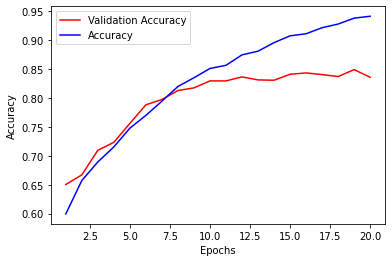

In [33]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         val_acc,
         label = 'Validation Accuracy',
         color = 'red')


plt.plot(np.arange(1 , 21, 1),
         train_acc,
         label = 'Accuracy',
         color = 'blue')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [34]:
test_pred = classifier.predict(X_test_s)

test_pred_class = test_pred.argmax(axis = 1)

In [35]:
y_test_class = y_test.argmax(axis = 1)

In [36]:
pd.crosstab(y_test_class, test_pred_class, rownames = ['classe réelle'], colnames = ['classe predites'])

classe predites,0,1
classe réelle,,
0,888,185
1,123,978


In [37]:
# Fonction faisant ressortir clairement la condition normale ou anormale
def condition_r(x):
    result = []
    for i in x:
        if i == 0:
            i = 'anomaly'
            result.append(i)
        else:
            i = 'normal'
            result.append(i)
    return result

In [38]:
# Résultats des predictions en fonction des types de machine

set_test = pd.concat([df_mel_test.iloc[X_test.index].reset_index(), 
                     pd.Series(condition_r(test_pred_class)).rename('predictions')], axis=1)    

pd.crosstab([set_test['machine_type'], set_test['condition']], columns = set_test['predictions'])

predictions             anomaly  normal
machine_type condition                 
ToyCar       anomaly        205      24
             normal           8     267
ToyConveyor  anomaly        157      58
             normal          20     503
fan          anomaly        224      49
             normal          30      54
pump         anomaly         72      25
             normal          18      56
slider       anomaly        153      16
             normal          20      42
valve        anomaly         77      13
             normal          27      56

In [39]:
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1073
           1       0.84      0.89      0.86      1101

    accuracy                           0.86      2174
   macro avg       0.86      0.86      0.86      2174
weighted avg       0.86      0.86      0.86      2174



### Deuxième modèle de convolution

Nous allons essayer d'améliorer le score en rajoutant des couches de convolution

In [40]:
# Ajout d'une couche de convolution

classifier2 = Sequential()

first_layer = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (64, 79, 1), activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2))

third_layer = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (64, 79, 1), activation = 'relu')

fourth_layer = MaxPooling2D(pool_size = (2, 2))

third_bis_layer = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', input_shape = (64, 79, 1), activation = 'relu')

fourth_bis_layer = MaxPooling2D(pool_size = (2, 2))

fifth_layer = Flatten()
sixth_layer = Dense(units = 128, activation='relu')
output_layer = Dense(units = 2, activation='softmax')

classifier2.add(first_layer)
classifier2.add(second_layer)
classifier2.add(third_layer)
classifier2.add(fourth_layer)
classifier2.add(third_bis_layer)
classifier2.add(fourth_bis_layer)

classifier2.add(fifth_layer)
classifier2.add(sixth_layer)
classifier2.add(output_layer)



classifier2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 60, 75, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 33, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 12, 32)         25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)              

In [41]:
classifier2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

training_history_2 = classifier2.fit(X_train_s, y_train, 
                                  validation_split = 0.2,
                                  epochs = 20,
                                  batch_size = 200)

Train on 6955 samples, validate on 1739 samples
Epoch 1/20
6955/6955 [==============================] - 83s 12ms/sample - loss: 0.6481 - accuracy: 0.6312 - val_loss: 0.6023 - val_accuracy: 0.6619
Epoch 2/20
6955/6955 [==============================] - 80s 11ms/sample - loss: 0.5648 - accuracy: 0.7170 - val_loss: 0.5281 - val_accuracy: 0.7464
Epoch 3/20
6955/6955 [==============================] - 79s 11ms/sample - loss: 0.4745 - accuracy: 0.7784 - val_loss: 0.4418 - val_accuracy: 0.7993
Epoch 4/20
6955/6955 [==============================] - 81s 12ms/sample - loss: 0.4110 - accuracy: 0.8128 - val_loss: 0.4271 - val_accuracy: 0.8085
Epoch 5/20
6955/6955 [==============================] - 80s 11ms/sample - loss: 0.3730 - accuracy: 0.8324 - val_loss: 0.4046 - val_accuracy: 0.8125
Epoch 6/20
6955/6955 [==============================] - 80s 12ms/sample - loss: 0.3304 - accuracy: 0.8569 - val_loss: 0.3731 - val_accuracy: 0.8327
Epoch 7/20
6955/6955 [==============================] - 81s 12ms

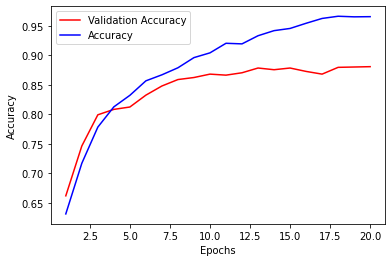

In [42]:
train_acc = training_history_2.history['accuracy']
val_acc = training_history_2.history['val_accuracy']

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 21, 1),
         val_acc,
         label = 'Validation Accuracy',
         color = 'red')


plt.plot(np.arange(1 , 21, 1),
         train_acc,
         label = 'Accuracy',
         color = 'blue')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

In [43]:
test_pred = classifier2.predict(X_test_s)

test_pred_class = test_pred.argmax(axis = 1)

In [44]:
y_test_class = y_test.argmax(axis = 1)

In [45]:
pd.crosstab(y_test_class, test_pred_class, rownames = ['classe réelle'], colnames = ['classe predites'])

classe predites,0,1
classe réelle,,
0,967,106
1,122,979


In [46]:
# Résultats des predictions en fonction des types de machine

set_test = pd.concat([df_mel_test.iloc[X_test.index].reset_index(), 
                     pd.Series(condition_r(test_pred_class)).rename('predictions')], axis=1)    

pd.crosstab([set_test['machine_type'], set_test['condition']], columns = set_test['predictions'])

predictions             anomaly  normal
machine_type condition                 
ToyCar       anomaly        205      24
             normal          10     265
ToyConveyor  anomaly        176      39
             normal          32     491
fan          anomaly        258      15
             normal          36      48
pump         anomaly         83      14
             normal          21      53
slider       anomaly        163       6
             normal          13      49
valve        anomaly         82       8
             normal          10      73

In [47]:
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1073
           1       0.90      0.89      0.90      1101

    accuracy                           0.90      2174
   macro avg       0.90      0.90      0.90      2174
weighted avg       0.90      0.90      0.90      2174



#### Les résultats obtenues en utilisant des algorithmes de deeplearning sont meilleurs que ceux en ML malgré la durée d'entrainement élevée

### Cependant ils sont difficilement applicable dans notre problème car toutes les données d'entrainement sont des machines normales. Une manière efficace d'aborder ce problème est l'auto encodeur présenté dans le notebook suivant